In [1]:
import xarray as xr
import intake
import xesmf as xe
import PyCO2SYS as pyco2
import matplotlib.pyplot as plt
import numpy as np
import gsw
from dask.diagnostics import ProgressBar
from cmip6_preprocessing.preprocessing import combined_preprocessing
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables

In [2]:
%load_ext memory_profiler

In [3]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

In [4]:
variables = ['dissic','talk', 'so', 'thetao', 'fgco2']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gn'],
             source_id=['IPSL-CM6A-LR'],
            member_id=['r11i1p1f1'])

cat = col.search(**query)

dd = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

dd = merge_variables(dd)
list(dd.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['IPSL-CM6A-LR.gn.historical.Omon.r11i1p1f1']

In [5]:
#############
### Not needed at the moment because I'm taking only one model and one member
#############
# # temp={}
# # for name,item in dd_gn.items():
# #     #print(name)
# #     #print(item.data_vars)
# #     present = item.data_vars
# #     if all(i in present for i in variables):
# #         #print(name)
# #         temp[name]=item
# # dd_gn = temp

# def pick_first_member(ds_list, **kwargs):
#     return ds_list[0]

# dd = combine_datasets(
#     dd,
#     pick_first_member,
#     match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
# )

#### Regrid first

In [5]:
# Regrid
targetgrid_ds = xe.util.grid_global(1.0, 1.0)
targetgrid_ds['lon'] = targetgrid_ds['lon']+180
targetgrid_ds['lon_b'] = targetgrid_ds['lon_b']+180
newcoords = {'x':targetgrid_ds['lon'][0,:],'y':targetgrid_ds['lat'][:,0]}

dd_regrid={}
for name,item in dd.items():
    regridder = xe.Regridder(item, targetgrid_ds, 'bilinear', 
                         periodic=True, ignore_degenerate=True)
    ds_regridded = regridder(item).assign_coords(**newcoords).chunk({'time':120,'lev':1})
    dd_regrid[name]=ds_regridded
list(dd_regrid.keys())

/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


['IPSL-CM6A-LR.gn.historical.Omon.r11i1p1f1']

#### Don't regrid (but still put into a dd_regrid to match the rest of the code)

In [5]:
dd_regrid={}
for name,item in dd.items():
    ds_regridded = item.chunk({'time':1}).unify_chunks()
    dd_regrid[name]=ds_regridded
list(dd_regrid.keys())

['IPSL-CM6A-LR.gn.historical.Omon.r11i1p1f1']

### Get ds from dd and calculate additional variables

In [6]:
ds = dd_regrid['IPSL-CM6A-LR.gn.historical.Omon.r11i1p1f1']#.isel(iselect)
ds['p'] = gsw.p_from_z(-1*ds['lev'], ds['lat'], geo_strf_dyn_height=0, sea_surface_geopotential=0)*xr.ones_like(ds['talk']) # expand along time dimension
ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], ds['p'])
ds = ds.transpose(*tuple(ds.dims))

### Functions to "wrap" PyCO2SYS calculation

In [7]:
def pyco2sys_np(talk,dissic,thetao,p,insitutemp):
    args = {'par1':talk,
            'par2':dissic,
            'par1_type':1,
            'par2_type':2,
            'pressure_out':0,
            'temperature_out':thetao, 
            'pressure':p,
            'temperature':insitutemp}
    return pyco2.sys(**args)['pCO2_out']

def pyco2sys_npwrapper_map(talk,dissic,thetao,p,insitutemp):
    '''Use map to calculate pyco2sys_np element wise.'''
    return np.array(list(map(pyco2sys_np,talk,dissic,thetao,p,insitutemp)))

def pyco2sys_npwrapper_split(talk,dissic,thetao,p,insitutemp,axis_number,nsplit):
    '''Split, calculate, and combine data for pyco2sys calculation.'''
    ns = nsplit
    nax = axis_number
    
    talk_split = np.split(talk,ns,nax)
    dissic_split = np.split(dissic,ns,nax)
    thetao_split = np.split(thetao,ns,nax)
    p_split = np.split(p,ns,nax)
    insitutemp_split = np.split(insitutemp,ns,nax)
    tmp=[]
    for s in range(ns):
        tmp.append(pyco2sys_np(talk_split[s],dissic_split[s],thetao_split[s],p_split[s],insitutemp_split[s]))
    return np.concatenate(tmp, nax)

def pyco2sys_wrapper(ds,extrawrapper=None):
    conversion = 1e6/1035
    talk = ds['talk']*conversion
    dissic = ds['dissic']*conversion
    thetao = ds['thetao']
    p = ds['p']
    insitutemp = ds['insitutemp']
    
#     tmp = pyco2sys_np(talk,dissic,thetao,p,insitutemp)
    if extrawrapper is None:
        tmp = pyco2sys_np(talk,dissic,thetao,p,insitutemp)
    elif extrawrapper=='map':
        tmp = pyco2sys_npwrapper_map(talk,dissic,thetao,p,insitutemp)
    elif extrawrapper=='split':
        tmp = pyco2sys_npwrapper_split(talk,dissic,thetao,p,insitutemp,ds['talk'].get_axis_num('lev'),len(ds['lev']))
    return ds['talk'].copy(data=tmp)

def pyco2sys(ds):
    return xr.map_blocks(pyco2sys_wrapper,ds,template=ds['talk'])

def pyco2sys_map(ds):
    return xr.map_blocks(pyco2sys_wrapper,ds,kwargs={'extrawrapper':'map'},template=ds['talk'])

def pyco2sys_split(ds):
    return xr.map_blocks(pyco2sys_wrapper,ds,kwargs={'extrawrapper':'split'},template=ds['talk'])

def pyco2sys_ufunc(ds):
    conversion = 1e6/1035
    return xr.apply_ufunc(pyco2sys_npwrapper_split,
                          ds['talk']*conversion,ds['dissic']*conversion,ds['thetao'],ds['p'],ds['insitutemp'],
                          ds['talk'].get_axis_num('x'),len(ds['x']),
                          output_dtypes='float',
                          dask='parallelized')

In [8]:
# ds['PpCO2'] = xr.map_blocks(pyco2sys_wrapper,ds,template=ds['talk'])
ds['PpCO2'] = pyco2sys_map(ds)
# # ds['PpCO2'] = pyco2sys_ufunc(ds)
ds['PpCO2']

<xarray.DataArray 'PpCO2' (lev: 75, time: 1980, x: 362, y: 332)>
dask.array<pyco2sys_wrapper-a7f565270d0125eb7d27c80a3f706509-<this, shape=(75, 1980, 362, 332), dtype=float32, chunksize=(75, 1, 362, 332), chunktype=numpy.ndarray>
Coordinates:
    lat      (x, y) float32 dask.array<chunksize=(362, 332), meta=np.ndarray>
    lon      (x, y) float32 dask.array<chunksize=(362, 332), meta=np.ndarray>
  * lev      (lev) float64 0.5058 1.556 2.668 ... 5.495e+03 5.698e+03 5.902e+03
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 353 354 355 356 357 358 359 360 361
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 323 324 325 326 327 328 329 330 331
Attributes:
    cell_measures:       area: areacello volume: volcello
    cell_methods:        area: mean where sea time: mean
    description:         total alkalinity equivalent concentration (including...
    history:             none
    interval_operation:  2700 s
    interval_write:      1 month
    long_name:           Total Alkalinity
    online_operation:    average
    standard_name:       sea_water_alkalinity_expressed_as_mole_equivalent
    units:               mol/m³

In [ ]:
with ProgressBar():
    da = ds['PpCO2'].isel(time=slice(0,12)).load() #isel(time=slice(0,12)).mean(['time']).

[######################################  ] | 96% Completed | 17min  6.1s

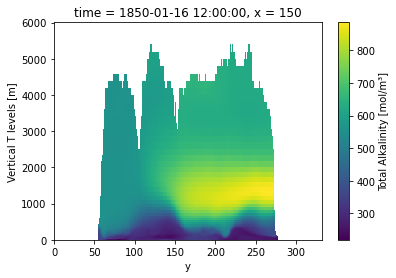

In [12]:
da.isel(x=150).plot()